<a href="https://colab.research.google.com/github/jennahgosciak/nyc_fire_risk/blob/main/00_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

root= r"C:/Users/Jennah/Desktop/Code/nyc_fire_risk"

# Estimating Fire Casualties in NYC
In NYC, recent fires--like the fire that occurred recently in the Bronx, in which 17 people died--have been devasting. It is important for cities to develop better tools for understanding where such catastrophic events might occur and target these areas for better prevention measures. Specifically, while a building may receive numerous violations from the New York City Housing and Preservation Department (HPD), HPD in turn may not know which buildings to target and when such violations are serious.

I propose a predictive model that calculates the risk of a __catastrophic__ fire using variables not considered in other models.

* I incorporate water and electricity use, as a measure of crowding in the building.
* I use data on past violations in the building, as a measure of a negligent landlord.
* Data on median household income in the surrounding area.
* Population density in the surrounding area.
* Average daily temperature.
* Number of residential building units and building FAR.

# Load data on fire dispatch events
## From January 1st, 2017 through the present
* Create a plot of fire events each year
* Only structural fires are included


In [2]:
# load data on all fire dispate events for structural fires
url_fire_ev = 'https://data.cityofnewyork.us/resource/8m42-w767.csv?$limit=1000000&$where=incident_datetime>="2017-01-01"%20AND%20INCIDENT_CLASSIFICATION_GROUP="Structural%20Fires"'
fire_ev = pd.read_csv(url_fire_ev)
print(fire_ev.shape)

# if false, then we might not have downloaded all data
print(fire_ev.shape[0])
assert fire_ev.shape[0] < 1000000

(115079, 29)
115079


In [3]:
# create month, date, and year variables
fire_ev["incident_date"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.date
fire_ev["incident_month"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.month
fire_ev["incident_day"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.day
fire_ev["incident_year"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.year

fire_ev["incident_md"]= fire_ev[["incident_month", "incident_day"]].astype(str).apply('-'.join, 1)

## More fire events occur in late November, December, and early January

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Jennah\AppData\Local\Temp/ipykernel_62364/2854213147.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x is not ''])


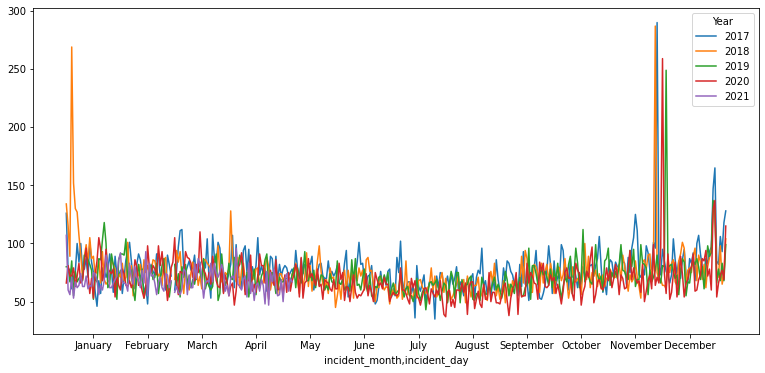

In [4]:
# plot dispatch events over time
fire_ev_plt_df= fire_ev.groupby(["incident_year", "incident_month", "incident_day"]).size().unstack(level = 'incident_year')
fire_ev_plt_df.columns.name= "Year"

fig, ax = plt.subplots(figsize=(13, 6))
fire_ev_plt_df.plot(ax = ax)

x = [(x, 15) for x in list(range(1,13))]

plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x is not ''])
plt.savefig(os.join(root, "figs/fire_ev_line.pdf"))

# Load data on vacate orders from HPD, due to fire
## From January 1st, 2017 through the present

In [5]:
# load vacate orders
url_vac = 'https://data.cityofnewyork.us/resource/tb8q-a3ar.csv?$limit=1000000&$where=vacate_effective_date>="2017-01-01"%20AND%20primary_vacate_reason="Fire%20Damage"'
vac = pd.read_csv(url_vac)
print(vac.shape)

# if false, then we might not have downloaded all data
print(vac.shape[0])
assert vac.shape[0] < 1000000

(1560, 20)
1560


In [6]:
# create date, month, and year variables
vac["vacate_effective_date2"]= pd.to_datetime(vac["vacate_effective_date"]).dt.date
vac["vacate_effective_month"]= pd.to_datetime(vac["vacate_effective_date"]).dt.month
vac["vacate_effective_day"]= pd.to_datetime(vac["vacate_effective_date"]).dt.day
vac["vacate_effective_year"]= pd.to_datetime(vac["vacate_effective_date"]).dt.year

vac["vacate_effective_md"]= vac[["vacate_effective_month", "vacate_effective_day"]].astype(str).apply('-'.join, 1)

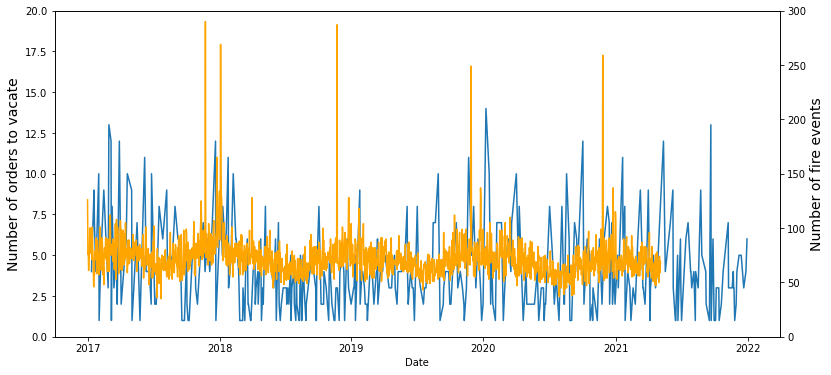

In [7]:
# create plots over time
fig, ax = plt.subplots(figsize=(13, 6))
vac.loc[vac["vacate_effective_year"] < 2022, :].groupby("vacate_effective_date2").size().plot(ax = ax)
ax.set_ylabel("Number of orders to vacate", fontsize=14)
ax.set_ylim([0, 20])

# set second axis
ax2=ax.twinx()
fire_ev.groupby("incident_date").size().plot(ax = ax2, color = "orange")
ax2.set_ylabel("Number of fire events", fontsize=14)
ax2.set_ylim([0, 300])

ax.set_xlabel("Date")
plt.savefig(os.join(root, "figs/vac_line.pdf"))

In [333]:
## load pluto
pluto= gpd.read_file(os.join(root, "data/nyc_mappluto_21v4_shp/MapPLUTO.shp"))
pluto_df= pd.DataFrame(pluto, copy = True)

KeyboardInterrupt: 

In [ ]:
## load pluto
pluto_df= pd.DataFrame(pluto, copy = True)

In [268]:
# merge to pluto
vac_pluto= pluto.merge(vac, how = "inner", right_on = "bbl", left_on = "BBL")
vac_pluto

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,council_district,census_tract,bin,bbl,nta,vacate_effective_date2,vacate_effective_month,vacate_effective_day,vacate_effective_year,vacate_effective_md
0,MN,237,11,102,1004100,10041004001,41,4001,02,1,...,1,41,1077452.0,1.002370e+09,SoHo-TriBeCa-Civic Center-Little Italy,2018-02-28,2,28,2018,2-28
1,MN,239,11,102,1004100,10041002001,41,2001,02,1,...,1,41,1003119.0,1.002390e+09,SoHo-TriBeCa-Civic Center-Little Italy,2020-01-08,1,8,2020,1-8
2,MN,297,7501,103,1001600,10016005000,16,5000,02,1,...,1,16,1003827.0,1.002978e+09,Chinatown,2021-04-01,4,1,2021,4-1
3,MN,271,51,103,1000600,10006004001,6,4001,02,1,...,1,6,1003237.0,1.002710e+09,Lower East Side,2019-01-11,1,11,2019,1-11
4,MN,253,1,103,1000800,10008004000,8,4000,02,1,...,1,8,1077585.0,1.002530e+09,Chinatown ...,2017-11-17,11,17,2017,11-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,SI,2922,1,501,5004003,50040032000,40,2000,31,49,...,49,40,5106237.0,5.029220e+09,Grymes Hill-Clifton-Fox Hills,2020-10-14,10,14,2020,10-14
1549,SI,3585,7502,502,5011402,50114022004,114.02,2004,31,50,...,50,11402,5109580.0,5.035858e+09,New Dorp-Midland Beach ...,2017-05-18,5,18,2017,5-18
1550,SI,3983,45,503,5012806,50128063000,128.06,3000,31,50,...,50,12806,5105548.0,5.039830e+09,Oakwood-Oakwood Beach,2020-10-14,10,14,2020,10-14
1551,SI,3983,45,503,5012806,50128063000,128.06,3000,31,50,...,50,12806,5105548.0,5.039830e+09,Oakwood-Oakwood Beach,2017-06-26,6,26,2017,6-26


(905464.7390380852, 1075092.8783935553, 112492.5738036365, 280480.09001457837)

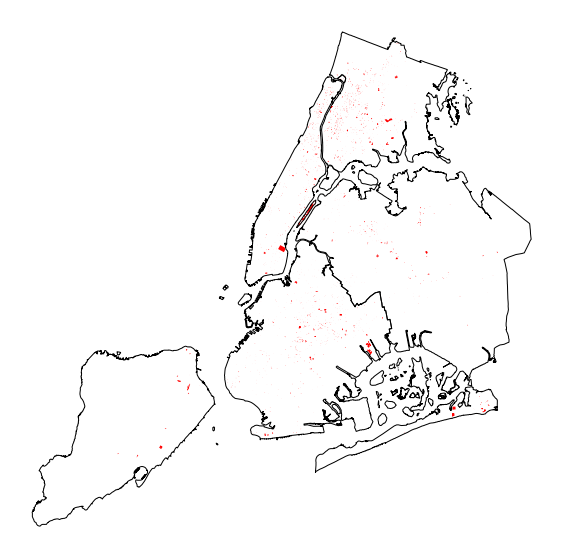

In [269]:
# load boros for background
# plot spatially
boros= gpd.read_file('https://data.cityofnewyork.us/resource/7t3b-ywvw.geojson').set_crs(4326).to_crs(2263)
fig,ax = plt.subplots(figsize=(15,10))

vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

(905464.7390380852, 1075092.8783935553, 112492.5738036365, 280480.09001457837)

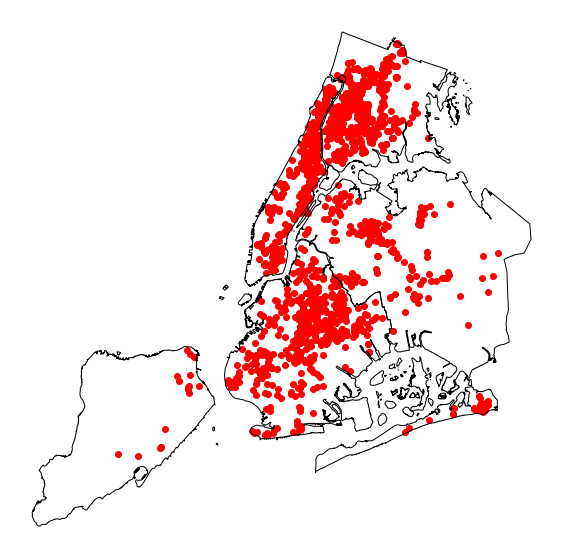

In [270]:
# convert to point data
vac_pluto["geometry"]= vac_pluto["geometry"].representative_point()

fig,ax = plt.subplots(figsize=(15,10))
vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

### Create heat map of fire vacate orders

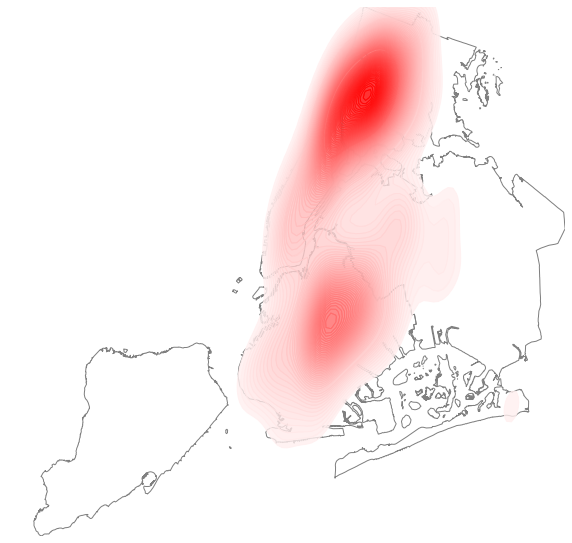

<Figure size 432x288 with 0 Axes>

In [271]:
# weight all the same
vac_pluto["weight"]= 1
# get extent
axis= boros.to_crs(4326).total_bounds
axis

# Calculate the KDE for heat map
data = np.c_[vac_pluto.longitude, vac_pluto.latitude]
kde = scipy.stats.gaussian_kde(data.T, bw_method="scott", weights=vac_pluto.weight)

# Compute std along axis
data_std = data.std(axis=0, ddof=1)
bw_x = getattr(kde, "scotts_factor")() * data_std[0]
bw_y = getattr(kde, "scotts_factor")() * data_std[1]
grid_x = grid_y = 100

x_support = seaborn.utils._kde_support(data[:, 0], bw_x, grid_x, 3, (axis[0], axis[2]))
y_support = seaborn.utils._kde_support(data[:, 1], bw_y, grid_y, 3, (axis[1], axis[3]))
xx, yy = np.meshgrid(x_support, y_support)
levels = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Create the map stretching over the requested area
ax = boros.to_crs(4326).plot(facecolor = 'none', edgecolor = 'gray',
                            figsize = (10, 10), alpha = 1)
cset = ax.contourf(xx, yy, levels,
    100,
    cmap=seaborn.palettes.blend_palette(('#ffffff10', '#ff0000af'), 100, as_cmap=True),
    antialiased=True,
    alpha = 0.8
)
# Hide lowest 4 levels
for i in range(0,5):
    cset.collections[i].set_alpha(0)
    
# remove lines on contour map
for c in cset.collections:
    c.set_edgecolor("face")
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()
plt.savefig(os.join(root, "figs/heatmap.pdf"), dpi=300, bbox_inches='tight')

## Load census data
* Plot median household income by census tract
* Will load additional variables
* From this [report](): “overcrowded” is more than one person per room, on average, and “severely overcrowded” is more than 1.5 persons per room.
    * Need to calculate whether census tract is overcrowded or not

In [285]:
# import census api
c = Census(config.api_key, year=2019)

# store census info in a dictionary
d = {}
           
for count in ['061', '085', '081', '047', '005']:
    # create temp for each county
    # all variables wanted
    temp= c.acs5.get(('NAME', 'B19013_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E',\
                                 'B25014_011E', 'B25014_012E', 'B25014_013E'),\
              {'for': 'tract:*', 'in': 'state:{} county:{}'.format(states.NY.fips, count)})
    
    d.update({(i["county"] + i["tract"]):i for i in temp})
d

{'061025500': {'NAME': 'Census Tract 255, New York County, New York',
  'B19013_001E': 66466.0,
  'B25014_001E': 2030.0,
  'B25014_005E': 0.0,
  'B25014_006E': 0.0,
  'B25014_007E': 0.0,
  'B25014_011E': 56.0,
  'B25014_012E': 83.0,
  'B25014_013E': 31.0,
  'state': '36',
  'county': '061',
  'tract': '025500'},
 '061022200': {'NAME': 'Census Tract 222, New York County, New York',
  'B19013_001E': 41250.0,
  'B25014_001E': 1459.0,
  'B25014_005E': 0.0,
  'B25014_006E': 0.0,
  'B25014_007E': 0.0,
  'B25014_011E': 9.0,
  'B25014_012E': 12.0,
  'B25014_013E': 22.0,
  'state': '36',
  'county': '061',
  'tract': '022200'},
 '061001001': {'NAME': 'Census Tract 10.01, New York County, New York',
  'B19013_001E': 81250.0,
  'B25014_001E': 842.0,
  'B25014_005E': 15.0,
  'B25014_006E': 0.0,
  'B25014_007E': 6.0,
  'B25014_011E': 0.0,
  'B25014_012E': 0.0,
  'B25014_013E': 0.0,
  'state': '36',
  'county': '061',
  'tract': '001001'},
 '061000700': {'NAME': 'Census Tract 7, New York County, New

In [286]:
# create med hh inc df
# create census df, rename cols using dict comprehension
oldcols= ['B19013_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E',\
                                 'B25014_011E', 'B25014_012E', 'B25014_013E']
newcols= ["medhhinc", "occ_total", "gt1_oo", "gt1_5_oo", "gt2_oo", "gt1_ro", "gt1_5_ro", "gt2_ro"]
census= pd.DataFrame.from_dict(d, orient = "index").rename({i:j for i,j in zip(oldcols, newcols)}, axis = 1).reset_index()\
            .rename({"index":"GEOID"}, axis = 1)

# load tract spatial data
tracts= gpd.read_file("https://data.cityofnewyork.us/resource/i69b-3rdj.geojson?$limit=100000")
# recode geoid var for merging
tracts["GEOID"]= np.where(
     tracts['boro_code'] == "5", 
    "085"+tracts["ct2010"], 
     np.where(
        tracts['boro_code'] == "1", 
    "061"+tracts["ct2010"],
         np.where(
        tracts['boro_code'] == "4", 
        "081"+tracts["ct2010"],
             np.where(
                tracts['boro_code'] == "3", 
            "047"+tracts["ct2010"],
                 np.where(
                    tracts['boro_code'] == "5", 
                "005"+tracts["ct2010"], '99999999'
                 )
             )
         )
     )
)
print(tracts["GEOID"].unique())
census

['085000900' '061009800' '061010200' ... '085022300' '085020700'
 '085021300']


,GEOID,NAME,medhhinc,occ_total,gt1_oo,gt1_5_oo,gt2_oo,gt1_ro,gt1_5_ro,gt2_ro,state,county,tract
0,061025500,"Census Tract 255, New York County, New York",66466.0,2030.0,0.0,0.0,0.0,56.0,83.0,31.0,36,061,025500
1,061022200,"Census Tract 222, New York County, New York",41250.0,1459.0,0.0,0.0,0.0,9.0,12.0,22.0,36,061,022200
2,061001001,"Census Tract 10.01, New York County, New York",81250.0,842.0,15.0,0.0,6.0,0.0,0.0,0.0,36,061,001001
3,061000700,"Census Tract 7, New York County, New York",184609.0,4391.0,0.0,13.0,47.0,68.0,449.0,49.0,36,061,000700
4,061010300,"Census Tract 103, New York County, New York",96071.0,1268.0,0.0,7.0,0.0,10.0,74.0,0.0,36,061,010300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,005037504,"Census Tract 375.04, Bronx County, New York",20644.0,1258.0,10.0,0.0,0.0,69.0,0.0,15.0,36,005,037504
2163,005038301,"Census Tract 383.01, Bronx County, New York",43155.0,1520.0,0.0,0.0,0.0,266.0,142.0,48.0,36,005,038301
2164,005038302,"Census Tract 383.02, Bronx County, New York",20519.0,2018.0,10.0,0.0,0.0,173.0,91.0,0.0,36,005,038302
2165,005039500,"Census Tract 395, Bronx County, New York",29000.0,1586.0,0.0,22.0,0.0,100.0,74.0,0.0,36,005,039500


In [287]:
# merge tracts to census data
tracts_census= tracts.merge(census, how = "inner", on = "GEOID")
tracts_census

tracts_census['Median HH Inc']= np.where(
     tracts_census['medhhinc'] < 0, np.nan,
    tracts_census['medhhinc'])

# check recoding
assert (tracts_census["Median HH Inc"].isna() == (tracts_census['medhhinc'].isna() | (tracts_census['medhhinc'] < 0))).all()

In [325]:
# create indicator for overcrowding variabel
tracts_census["sum_crowding"]= tracts_census[["gt1_oo", "gt1_5_oo", "gt2_oo", "gt1_ro", "gt1_5_ro", "gt2_ro"]].sum(axis = 1)
tracts_census["per_crowding"]= tracts_census.loc[:, "sum_crowding"].div(tracts_census.loc[:, "occ_total"]).fillna(0)

tracts_census["crowding_ind"]= np.where(
            tracts_census["per_crowding"]>=tracts_census["per_crowding"].mean(), 1, 0)
print("NYC Average from 2014-2019 ACS:", tracts_census["per_crowding"].mean())
print("\nCrosstab variable construction:")
print(tracts_census[["sum_crowding", "occ_total", "per_crowding"]].value_counts().sample(frac=0.025))
print("\nCheck indicator construction:")
print(tracts_census[["crowding_ind", "per_crowding"]].sample(frac=0.025).value_counts())

NYC Average from 2014-2019 ACS: 0.08730538000215304

Crosstab variable construction:
sum_crowding  occ_total  per_crowding
207.0         593.0      0.349073        1
49.0          612.0      0.080065        1
324.0         1218.0     0.266010        1
61.0          1893.0     0.032224        1
47.0          1015.0     0.046305        1
243.0         3250.0     0.074769        1
130.0         916.0      0.141921        1
33.0          482.0      0.068465        1
48.0          552.0      0.086957        1
157.0         1180.0     0.133051        1
33.0          2017.0     0.016361        1
72.0          611.0      0.117840        1
27.0          605.0      0.044628        1
219.0         1433.0     0.152826        1
21.0          462.0      0.045455        1
16.0          605.0      0.026446        1
95.0          1978.0     0.048028        1
116.0         2372.0     0.048904        1
164.0         3057.0     0.053647        1
78.0          793.0      0.098361        1
163.0         216

(-74.28337047811618, -73.67222994890716, 40.476988784652164, 40.89818324976431)

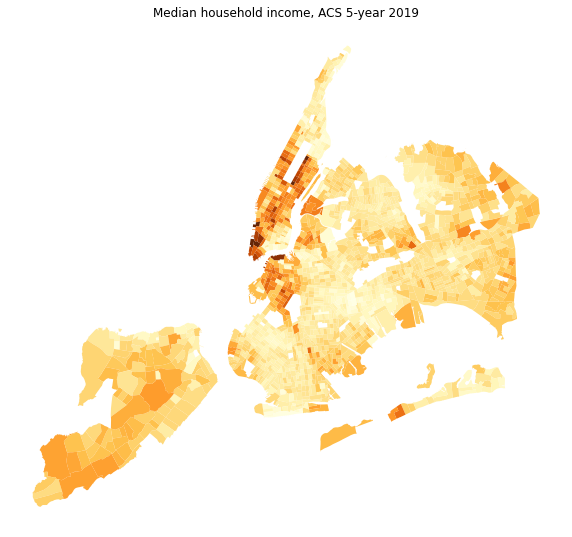

In [266]:
# plot median household income by census tract
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.plot(column= "Median HH Inc", cmap = "YlOrBr", ax = ax)
plt.title("Median household income, ACS 5-year 2019")
ax.axis('off')

(-74.28337047811618, -73.67222994890716, 40.476988784652164, 40.89818324976431)

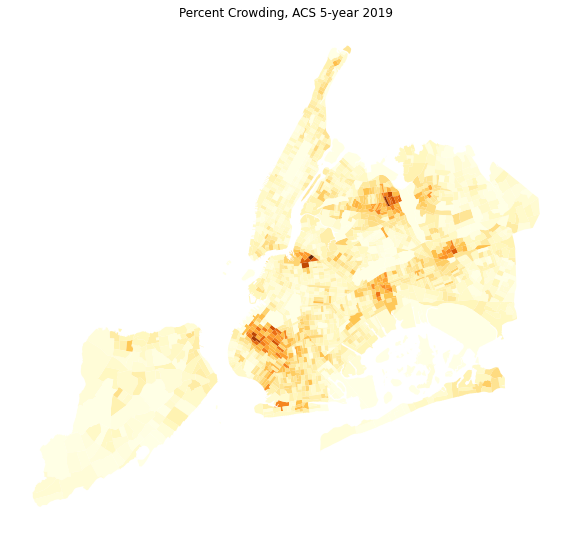

In [326]:
# plot percent crowding
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.plot(column= "per_crowding", cmap = "YlOrBr", ax = ax)
plt.title("Percent Crowding, ACS 5-year 2019")
ax.axis('off')

## Load data on electricity and water usage
* [2020 data](https://data.cityofnewyork.us/resource/usc3-8zwd.csv)
* [2019 data](https://data.cityofnewyork.us/resource/wcm8-aq5w.csv)
* [2018 data](https://data.cityofnewyork.us/resource/4tys-3tzj.csv)
* [2017 data](https://data.cityofnewyork.us/resource/4t62-jm4m.csv)

In [327]:
# store urls
url_2020= "https://data.cityofnewyork.us/resource/usc3-8zwd.csv?$limit=100000"
url_2019= "https://data.cityofnewyork.us/resource/wcm8-aq5w.csv?$limit=100000"
url_2018= "https://data.cityofnewyork.us/resource/4tys-3tzj.csv?$limit=100000"
url_2017= "https://data.cityofnewyork.us/resource/4t62-jm4m.csv?$limit=100000"

# load and append data from each year
urls= [url_2017, url_2018, url_2019, url_2020]
cols= [["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot_bbl",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources_kgal", "multifamily_housing_number_of_bedrooms",\
                                        "multifamily_housing_total_number_of_residential_living_units"]]
# read in all data files using lc, combine across the rows
dfs= [pd.read_csv(urls[i], usecols = cols[i]) for i in range(0, 4)]
dfs

[       property_id              year_ending  \
 0          4593574  2017-12-31T00:00:00.000   
 1          6224375  2017-12-31T00:00:00.000   
 2          2967701  2017-12-31T00:00:00.000   
 3          4898531  2017-12-31T00:00:00.000   
 4          2917939  2017-12-31T00:00:00.000   
 ...            ...                      ...   
 34681      4047752  2017-12-31T00:00:00.000   
 34682      6682473  2017-12-31T00:00:00.000   
 34683      6682474  2017-12-31T00:00:00.000   
 34684      6682477  2017-12-31T00:00:00.000   
 34685      2819133  2017-12-31T00:00:00.000   
 
                                 property_name  nyc_borough_block_and_lot  \
 0                       The Argonaut Building                 1010287502   
 1                             Operative Cakes  2-00560-0062;2-05560-0062   
 2              Cathedral Preparatory Seminary               4-01872-0007   
 3                             The Nomad Hotel               1-00829-0050   
 4                      10 West 27 St

In [328]:
# make names of columns uniform
dfs[0].columns = cols[0]
dfs[1].columns = cols[0]
dfs[2].columns = cols[0]
dfs[3].columns = cols[0]

# concatenate along rows (i.e. append data from each year)
df_ew= pd.concat(dfs, axis = 0)
df_ew

,property_id,year_ending,property_name,nyc_borough_block_and_lot,occupancy,year_built,number_of_buildings,water_use_all_water_sources,multifamily_housing_number,multifamily_housing_total
0,4593574,2017-12-31T00:00:00.000,The Argonaut Building,1010287502,1909,1,95,NaN,NaN,3635.5
1,6224375,2017-12-31T00:00:00.000,Operative Cakes,2-00560-0062;2-05560-0062,1973,2,100,NaN,NaN,116.0
2,2967701,2017-12-31T00:00:00.000,Cathedral Preparatory Seminary,4-01872-0007,1963,1,100,NaN,NaN,102.9
3,4898531,2017-12-31T00:00:00.000,The Nomad Hotel,1-00829-0050,1999,1,85,NaN,NaN,10762.6
4,2917939,2017-12-31T00:00:00.000,10 West 27 Street Corp,1-00828-0053,1994,1,100,NaN,NaN,790.1
...,...,...,...,...,...,...,...,...,...,...
28062,17286197,ACF - 129th St Residence - 109 West 129th St: ...,2020-12-31T00:00:00.000,1-01914-0026,1920,1,100,Not Available,Not Available,Not Available
28063,17298485,110-31 Merrick Boulevard,2020-12-31T00:00:00.000,4102700059,1997,1,100,Not Available,Not Available,Not Available
28064,17298486,110-31A Merrick Boulevard,2020-12-31T00:00:00.000,4102700047,1997,1,100,Not Available,Not Available,Not Available
28065,17321529,402 EAST 78 STREET,2020-12-31T00:00:00.000,1014720046,1910,1,100,52,39,1788.6


In [329]:
# text formatting of bbl
df_ew.loc[:, "bbl"]= df_ew.iloc[:, 3].str.replace("[A-z]{1}[0-9]{3}-", "", regex = True)
df_ew.loc[:, "bbl"]= df_ew.loc[:, "bbl"].str.replace("-", "").str.replace(" ", ";")\
                        .str.replace("(?<=[0-9]{10})/", ";", regex = True)\
                        .str.replace("/", "")\
                        .str.replace(",", ";")\
                        .str.replace(":", ";")\
                        .str.replace("and", ";")\
                        .str.replace("&", ";")\
                        .str.replace("NotAvailable", "")\
                        .str.replace("multiple", "")
df_ew.loc[:, "bbl"]

0                   1010287502
1        2005600062;2055600062
2                   4018720007
3                   1008290050
4                   1008280053
                 ...          
28062               1019140026
28063               4102700059
28064               4102700047
28065               1014720046
28066               4102700057
Name: bbl, Length: 117082, dtype: object

In [330]:
# need to split bbl into several columns
max_num= int(df_ew["bbl"].str.count(";").max())
df_ew[["bbl" + str(i) for i in range(0, (max_num + 1))]]= df_ew["bbl"].str.split(pat= ";", n=-1, expand = True)
df_ew[["bbl" + str(i) for i in range(0, (max_num + 1))]]

,bbl0,bbl1,bbl2,bbl3,bbl4,bbl5,bbl6,bbl7,bbl8,bbl9,...,bbl32,bbl33,bbl34,bbl35,bbl36,bbl37,bbl38,bbl39,bbl40,bbl41
0,1010287502,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2005600062,2055600062,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,4018720007,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,1008290050,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,1008280053,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28062,1019140026,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
28063,4102700059,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
28064,4102700047,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
28065,1014720046,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [331]:
# reshape and reformat bbl column
# pivot data long using melt
cols = [x for x in df_ew.columns if x not in ["bbl" + str(i) for i in range(0, max_num)] + ["bbl"]]
cols

# melt pivots data long
df_ewlong= pd.melt(df_ew.drop("bbl", axis = 1), id_vars=cols,var_name='bbl_num', value_name='bbl')
# recode comparison
print(df_ewlong[["bbl", "nyc_borough_block_and_lot"]].dropna().loc[(df_ewlong["bbl"].dropna()).map(len) > 10, :])

df_ewlong= df_ewlong[(df_ewlong["bbl"].notna()) | (df_ewlong["bbl"].isna() & \
                                                         df_ewlong["bbl_num"] == "bbl0")].drop_duplicates()

                  bbl                          nyc_borough_block_and_lot
61      0004033410037                                    0004-03341-0037
319       1005800065.                                      1-00580-0065.
2061      10193100006                                      1-01931-00006
4018      1005800065.                                      1-00580-0065.
4290      20028110024                                        20028110024
...               ...                                                ...
482954    05006200200  05-00620-0001; 05-00620-0100; 05-00620-0200; 0...
516925    30605000019  3-06050-0051; 3-06050-0059; 3-06050-00019; 3-0...
541896    30605000019    3060500051; 3060500059; 30605000019; 3060500015
569611    30605000019    3060500051; 3060500059; 30605000019; 3060500015
717118    05006200300  05-00620-0001; 05-00620-0100; 05-00620-0200; 0...

[69 rows x 2 columns]


In [332]:
# drop if not useful
df_ewlong= df_ewlong.drop(df_ewlong.loc[(df_ewlong["bbl"].str.len() != 10) | \
                (df_ewlong["bbl"] == "Code9Code9") | \
                (df_ewlong["bbl"] == "Not Available") | \
                (df_ewlong["bbl"] == "XXXXXXXXXX"), :].index, axis = 0)

In [81]:
# clean total housing units data
df_ewlong.loc[(df_ewlong["multifamily_housing_total"] == "0") | \
              (df_ewlong["multifamily_housing_total"] == "Not Available"), "multifamily_housing_total"]= ""
df_ewlong["multifamily_housing_total"]= pd.to_numeric(df_ewlong["multifamily_housing_total"])

In [82]:
# calculate water usage per unit (can also be calculated for comparison using resunits from pluto)
df_ewlong["water_num"]= pd.to_numeric(df_ewlong["water_use_all_water_sources"].str.replace("Not Available", ""))
# fill missing values with 0s
df_ewlong["pwater_num"]= df_ewlong["water_num"].div(df_ewlong["multifamily_housing_total"].astype(float), \
                                                       fill_value = 0).fillna(0)

In [84]:
# merge to pluto and main df
print(df_ewlong[["bbl","pwater_num", "water_num", "multifamily_housing_total"]].head())
# need to convert bbl to string
vac_pluto["bbl"]= vac_pluto["bbl"].astype(str).str.replace(".0", "", regex = False)
assert (vac_pluto["bbl"].str.len() == 10).all()
assert (df_ewlong["bbl"].str.len() == 10).all()

vac_pluto_ew= pd.merge(vac_pluto, df_ewlong, how = "left", on = "bbl")
print(vac_pluto_ew.shape)
print(vac_pluto_ew.loc[vac_pluto_ew["property_id"].notna(), :].shape)
print(vac_pluto_ew.loc[vac_pluto_ew["property_id"].isna(), :].shape)
print(vac_pluto_ew.loc[(vac_pluto_ew["property_id"].isna()) & \
                       (vac_pluto_ew["BldgArea"] < 25000), "BldgArea"].shape)

          bbl  pwater_num  water_num  multifamily_housing_total
0  1010287502         0.0        NaN                     3635.5
1  2005600062         0.0        NaN                      116.0
2  4018720007         0.0        NaN                      102.9
3  1008290050         0.0        NaN                    10762.6
4  1008280053         0.0        NaN                      790.1
(4399, 135)
(3669, 135)
(730, 135)
(708,)


## Load HPD Housing Code Violations
* Data saved on the [NYC Open Data Portal](https://data.cityofnewyork.us/resource/wvxf-dwi5.csv)
* Load Class C Violations (Class C are most severe)
* All violation filings since January 1st, 2017

In [103]:
import psycopg2 as psy
# load furman db
connection = psy.connect(
    host="fcdata.c7h93yqbqnvu.us-east-1.rds.amazonaws.com",
    port=5432,
    user = "furmandata",
    password = config.furman_pwd,
    database = "fcdata")
cursor = connection.cursor()

In [128]:
viol_summary= pd.read_sql("""SELECT violation_class, bbl, Count(*) FROM hpd_violations
                            WHERE inspection_date >= '2017-01-01'
                            GROUP BY violation_class, bbl;""", con=connection)
viol_summary= viol_summary.drop(viol_summary[(viol_summary["bbl"]=='0         ') | \
                                             (viol_summary["bbl"].isna())].index, axis = 0)
assert (viol_summary["bbl"].str.len() == 10).all()
viol_summary.head()

In [150]:
# convert bbl to string
viol_summary["bbl"]= viol_summary["bbl"].astype(str).str.replace(".0", "", regex = False)
viol_summary= viol_summary.rename({"count":"num_viol"}, axis = 1)

In [203]:
# pivot data wider
viol_wide= viol_summary.pivot(index='bbl', columns='violation_class', values = 'num_viol').fillna(0).reset_index()
viol_wide.head()

violation_class,bbl,A,B,C,I
0,1000070038,1.0,0.0,0.0,0.0
1,1000077501,15.0,6.0,9.0,1.0
2,1000077502,1.0,0.0,0.0,2.0
3,1000080039,1.0,0.0,0.0,2.0
4,1000100033,1.0,0.0,0.0,4.0


In [210]:
vac_pluto_viol= pd.merge(vac_pluto_ew, viol_wide, how = "left", on = "bbl")
# fill missing values with 0
print(vac_pluto_viol.head())
print("Average number of class C violations:", vac_pluto_viol["C"].mean())

  Borough  Block   Lot   CD  BCT2020    BCTCB2020 CT2010 CB2010 SchoolDist  \
0      MN    237    11  102  1004100  10041004001     41   4001         02   
1      MN    239    11  102  1004100  10041002001     41   2001         02   
2      MN    297  7501  103  1001600  10016005000     16   5000         02   
3      MN    271    51  103  1000600  10006004001      6   4001         02   
4      MN    253     1  103  1000800  10008004000      8   4000         02   

   Council  ...  multifamily_housing_number multifamily_housing_total  bbl41  \
0        1  ...                         NaN                       NaN    NaN   
1        1  ...                         NaN                       NaN    NaN   
2        1  ...                         NaN                       NaN    NaN   
3        1  ...                         NaN                       NaN    NaN   
4        1  ...                      1590.0                       NaN   None   

   bbl_num  water_num pwater_num     A     B     C